In [1]:
!pip install catboost

# Importação de Bibliotecas

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from lightgbm import early_stopping

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt

from AleFuncoes import CortaIntervalosQuasiUniforme
from AleFuncoes import CortaIntervalosGanhoInformacao

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = pd.errors.SettingWithCopyWarning)

# Split Conjunto Treino/Teste

In [3]:
alvo = 'Churn'
df_tot = pd.read_csv('telco-customer-churn-real.zip', dtype = {'SeniorCitizen': str})
df_tot[alvo] = df_tot[alvo].map({'Yes': 1, 'No': 0})
df_tot.loc[df_tot['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_tot['TotalCharges'] = df_tot['TotalCharges'].astype(float)

In [4]:
df_teste = df_tot.sample(frac = 0.5, random_state = 42)
df = df_tot[~df_tot.index.isin(df_teste.index)]

In [5]:
display(display(df_tot[['Partner', alvo]].groupby('Partner').agg(['count', 'mean'])))

Churn          
        count      mean
Partner                
No       1831  0.320590
Yes      1690  0.198817

None

# Tratamento de Features

In [6]:
colunas_id = ['customerID']
features_categoricas = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
features_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [7]:
dict_dummies = {'Partner': ['No']}
for f in [v for v in features_categoricas if v != 'Partner']:
    lista_dummies = list(df[f].value_counts().index[:-1])
    dict_dummies[f] = lista_dummies

for k,v in dict_dummies.items():
    for value in v:
        df[k + '_' + value] = (df[k] == value).astype(int)
        df_teste[k + '_' + value] = (df_teste[k] == value).astype(int)
    df.drop(k, axis = 1, inplace = True)
    df_teste.drop(k, axis = 1, inplace = True)
df.columns = [c.replace(' ', '_') for c in df.columns]
df_teste.columns = [c.replace(' ', '_') for c in df_teste.columns]

In [8]:
features = [v for v in df.columns if v not in colunas_id and v != alvo]

In [9]:
features_remover = ['PaymentMethod_Electronic_check',
                    'TechSupport_No',
                    'TotalCharges',
                    'Dependents_No',
                    'OnlineBackup_No',
                    'PaperlessBilling_Yes',
                    'MultipleLines_No',
                    'StreamingMovies_Yes',
                    'Partner_No',
                    'SeniorCitizen_0',
                    'DeviceProtection_No',
                    'PhoneService_Yes',
                    'MultipleLines_Yes',
                    'StreamingTV_Yes',
                    'gender_Male',
                    'PaymentMethod_Bank_transfer_(automatic)',
                    'InternetService_DSL',
                    'OnlineSecurity_Yes',
                    'PaymentMethod_Mailed_check',
                    'OnlineBackup_Yes',
                    'StreamingTV_No',
                    'DeviceProtection_Yes',
                    'TechSupport_Yes',
                    'StreamingMovies_No',
                    ]



features = [v for v in features if v not in features_remover]

# Treinamentos

In [10]:
treinar_catboost = True
usar_teste_treinamento = False #Simula vazamento de informação

In [11]:
def funcao_de_treinamento(frac):
    #Simula treinar com uma amostra da base
    df_train = df.sample(frac = frac, random_state = 42)

    X = df_train[features]
    y = df_train[alvo].astype(int)

    lista_modelos = []
    for i in range(0, 10):
        df_t = df_train.sample(frac = 0.5, random_state = i)
        df_v = df_train[~df_train.index.isin(df_t.index)]
        X_t = df_t[features]
        y_t = df_t[alvo].astype(int)
        X_v = df_v[features]
        y_v = df_v[alvo].astype(int)

        if treinar_catboost:
            clf = CatBoostClassifier(
                                loss_function = 'Logloss',
                                use_best_model = True,
                                random_state = 42,
                                verbose = 0,

                                l2_leaf_reg = 0,
                                max_depth = 1, #Quando mais rasa as árvores menor (mais simples)
                                learning_rate = 0.01, #Quanto menor o learning_rate menor (menos incremento no modelo por iteração)
                                n_estimators = 10000 #Vamos forçar até o limite do overfitting
                                )
        else:
            clf = LGBMClassifier(
                                objective = 'binary',
                                boosting_type = 'gbdt',
                                force_row_wise = True,
                                random_state = 42,
                                n_jobs = -1,
                                verbose = -1,

                                max_depth = 1, #Quando mais rasa as árvores menor (mais simples)
                                learning_rate = 0.01, #Quanto menor o learning_rate menor (menos incremento no modelo por iteração)
                                n_estimators = 20000 #Vamos forçar até o limite do overfitting
                                )

        if usar_teste_treinamento:
            if treinar_catboost:
                clf.fit(
                        X, y,
                        eval_set = [(X, y), (df_teste[features], df_teste[alvo])],
                        early_stopping_rounds = 3000
                        )
            else:
                clf.fit(
                        X, y,
                        eval_set = [(X, y), (df_teste[features], df_teste[alvo])],
                        callbacks = [early_stopping(stopping_rounds = 3000, verbose = True)]
                        )
        else:
            if treinar_catboost:
                clf.fit(
                        X_t, y_t,
                        eval_set = [(X_t, y_t), (X_v, y_v)],
                        early_stopping_rounds = 3000
                        )
            else:
                clf.fit(
                        X_t, y_t,
                        eval_set = [(X_t, y_t), (X_v, y_v)],
                        callbacks = [early_stopping(stopping_rounds = 3000, verbose = True)]
                        )

        lista_modelos.append(clf)

    probs = np.mean([m.predict_proba(X)[:, 1] for m in lista_modelos], axis = 0)

    df_metrics_treino = pd.DataFrame([[roc_auc_score(y, probs), ks_2samp(probs[y == 0], probs[y == 1]).statistic]],
                                    columns = ['AUC', 'KS'],
                                    index = ['Treino'])

    X_teste = df_teste[features]
    y_teste = df_teste[alvo]

    probs_teste = np.mean([m.predict_proba(X_teste)[:, 1] for m in lista_modelos], axis = 0)

    df_metrics_teste = pd.DataFrame([[roc_auc_score(y_teste, probs_teste), ks_2samp(probs_teste[y_teste == 0], probs_teste[y_teste == 1]).statistic]],
                                    columns = ['AUC', 'KS'],
                                    index = ['Teste'])

    df_resumo = pd.concat([df_metrics_treino, df_metrics_teste])
    df_resumo['Frac'] = frac
    return df_resumo

In [12]:
lista_df_resumo = []
for frac in np.arange(0.05, 1 + 0.05, 0.05):
    df_resumo = funcao_de_treinamento(frac)
    display(df_resumo)
    lista_df_resumo.append(df_resumo)

,AUC,KS,Frac
Treino,0.888690,0.661905,0.05
Teste,0.800929,0.449889,0.05


,AUC,KS,Frac
Treino,0.825295,0.539082,0.1
Teste,0.800366,0.454155,0.1


,AUC,KS,Frac
Treino,0.817238,0.496528,0.15
Teste,0.823067,0.499085,0.15


,AUC,KS,Frac
Treino,0.813867,0.486598,0.2
Teste,0.827496,0.496404,0.2


,AUC,KS,Frac
Treino,0.813333,0.487369,0.25
Teste,0.833521,0.508822,0.25


,AUC,KS,Frac
Treino,0.816753,0.500884,0.3
Teste,0.834674,0.509443,0.3


,AUC,KS,Frac
Treino,0.825262,0.524390,0.35
Teste,0.835506,0.512248,0.35


,AUC,KS,Frac
Treino,0.816925,0.503015,0.4
Teste,0.835583,0.517474,0.4


,AUC,KS,Frac
Treino,0.817082,0.488219,0.45
Teste,0.838064,0.518862,0.45


,AUC,KS,Frac
Treino,0.818883,0.495871,0.5
Teste,0.834573,0.508328,0.5


,AUC,KS,Frac
Treino,0.822996,0.517408,0.55
Teste,0.836074,0.515975,0.55


,AUC,KS,Frac
Treino,0.830725,0.532911,0.6
Teste,0.835449,0.514227,0.6


,AUC,KS,Frac
Treino,0.826383,0.512562,0.65
Teste,0.837038,0.518134,0.65


,AUC,KS,Frac
Treino,0.823041,0.500968,0.7
Teste,0.833382,0.508590,0.7


,AUC,KS,Frac
Treino,0.822852,0.502828,0.75
Teste,0.835972,0.510777,0.75


,AUC,KS,Frac
Treino,0.825710,0.507165,0.8
Teste,0.835047,0.513871,0.8


,AUC,KS,Frac
Treino,0.822389,0.501700,0.85
Teste,0.836164,0.516251,0.85


,AUC,KS,Frac
Treino,0.828502,0.506245,0.9
Teste,0.835593,0.512908,0.9


,AUC,KS,Frac
Treino,0.829739,0.513558,0.95
Teste,0.836878,0.522645,0.95


,AUC,KS,Frac
Treino,0.834004,0.513446,1.0
Teste,0.836559,0.515564,1.0


# Análise de Comportamento por Fração da Base de Treino

In [13]:
df_resumo_tot = pd.concat(lista_df_resumo)
df_resumo_tot = df_resumo_tot.reset_index()
df_resumo_tot = df_resumo_tot[['index', 'Frac', 'AUC', 'KS']].rename({'index': 'Conjunto'}, axis = 1)

In [14]:
def plot_metric(df: pd.DataFrame, metric: str, ylim=None):
    """
    Plota a métrica (AUC ou KS) por Frac para Treino e Teste.
    - df precisa ter colunas: Conjunto ('Treino'/'Teste'), Frac, e a métrica.
    - ylim: tupla (ymin, ymax) opcional para ajustar o eixo Y.
    """
    # Garantir tipos corretos e ordenar por Frac
    work = df.copy()
    work["Frac"] = work["Frac"].astype(float)
    work = work.sort_values("Frac")

    # Pivotar: linhas = Frac, colunas = Conjunto, valores = métrica
    wide = work.pivot(index="Frac", columns="Conjunto", values=metric)
    # Manter ordem Treino / Teste se ambas existirem
    cols = [c for c in ["Treino", "Teste"] if c in wide.columns]
    wide = wide[cols]

    # Cria a figura (um gráfico por chamada)
    plt.figure(figsize=(9, 5.5))
    # Linhas com marcadores (sem escolher cores explicitamente)
    for col in cols:
        plt.plot(wide.index, wide[col], marker="o", linewidth=2, markersize=6, label=col)

    # Rótulos e aparência
    plt.title(f"Evolução do {metric} em função da fração da base de treinamento", fontsize=12)
    plt.xlabel("Fração da base de treinamento (Frac)")
    plt.ylabel(metric)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Conjunto", frameon=False)
    plt.tight_layout()

    # Anotação de tendência no TESTE (se existir)
    if "Teste" in wide.columns and wide["Teste"].notna().sum() >= 2:
        x = wide.index.values.astype(float)
        y = wide["Teste"].values.astype(float)
        # Ajuste linear simples para inferir tendência
        slope = np.polyfit(x, y, 1)[0]
        # Posição bacana para anotação
        xy = (x[-1], y[-1])
        xytext = (x[max(1, len(x)//2)] if len(x) > 2 else x[0], np.nanmin(y) + 0.02)
        texto = "Mais dados → tendência de melhora no Teste" if slope > 0 else "Tendência no Teste"
        plt.annotate(
            texto,
            xy=xy, xytext=xytext,
            arrowprops=dict(arrowstyle="->", lw=1),
            fontsize=9
        )

    plt.show()

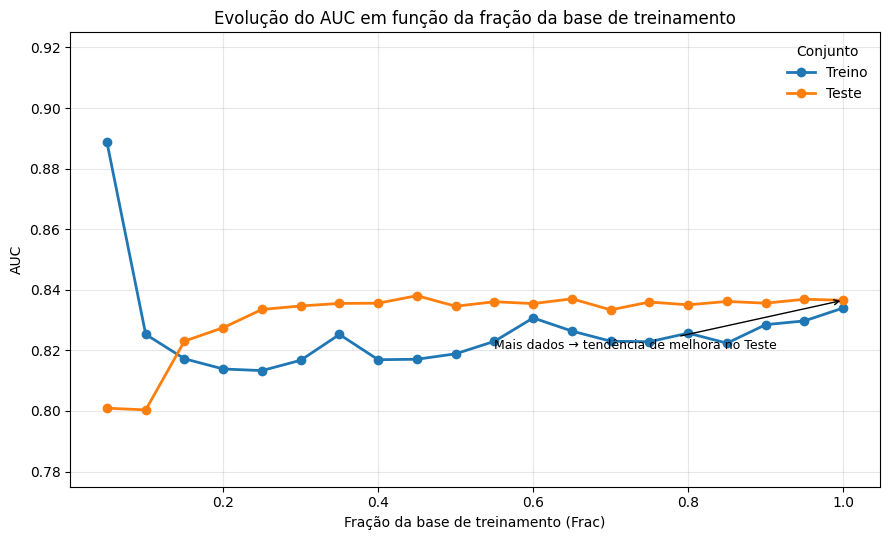

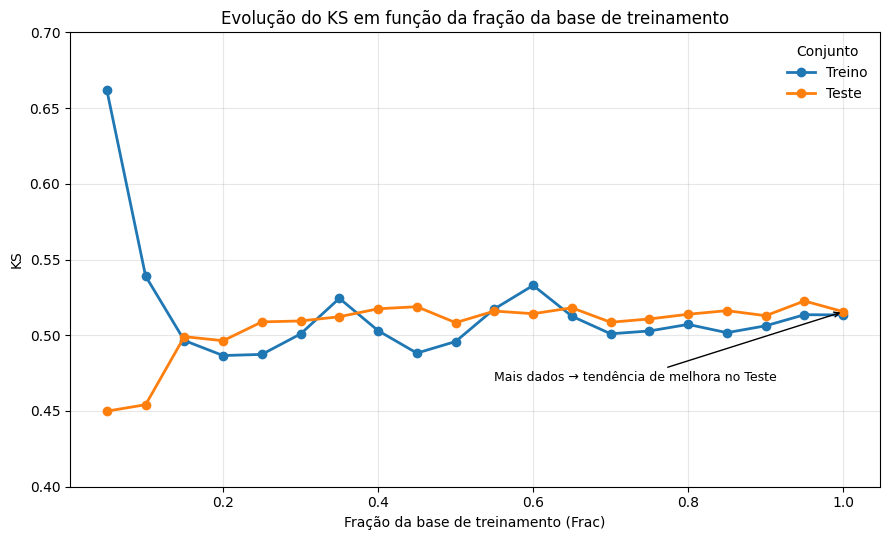

In [15]:
plot_metric(df_resumo_tot, metric="AUC", ylim=(0.775, 0.925))  # intervalo típico para AUC
print('')
plot_metric(df_resumo_tot, metric="KS",  ylim=(0.4, 0.7))  # KS varia de 0 a 1